1. Setup and Load data

1.1 Install libraries

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

1.2 Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir='data'

In [7]:
os.listdir(data_dir)

['Cracked capsule', 'RED CIRCLE CAPSULES', 'White oblong capsule']

In [8]:
img_exts=['jpg','jpeg','bmp','png']

In [10]:
for img_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,img_class)):
    image_path=os.path.join(data_dir,img_class,image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in img_exts:
        os.remove(image_path)
        print('removed ',image_path)
    except Exception as e:
      print('failed to load ',image_path)


1.3 Load data

In [ ]:
tf.data.Dataset??

In [ ]:
tf.keras.utils.image_dataset_from_directory??

In [283]:
import numpy as np
from matplotlib import pyplot as plt

In [284]:
data=tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32)

Found 313 files belonging to 3 classes.


In [192]:
#data_iterator=data.as_numpy_iterator()

In [193]:
#batch=data_iterator.next()

In [194]:
#fig,ax=plt.subplots(ncols=4,figsize=(20,20))
#for idx,img in enumerate(batch[0][:4]):
 # ax[idx].imshow(img.astype(int))
  #ax[idx].title.set_text(batch[1][idx])

In [195]:
  #scaled=batch[0]/255

In [196]:
#scaled.max()

2. Pre process the data

2.1 Data scaling

In [285]:
data = data.map(lambda x, y: (x / 255.0, tf.one_hot(y, depth=3)))


In [302]:
scaled_iterator=data.as_numpy_iterator()

In [303]:
batch=scaled_iterator.next()

In [304]:
batch[0].max()

1.0

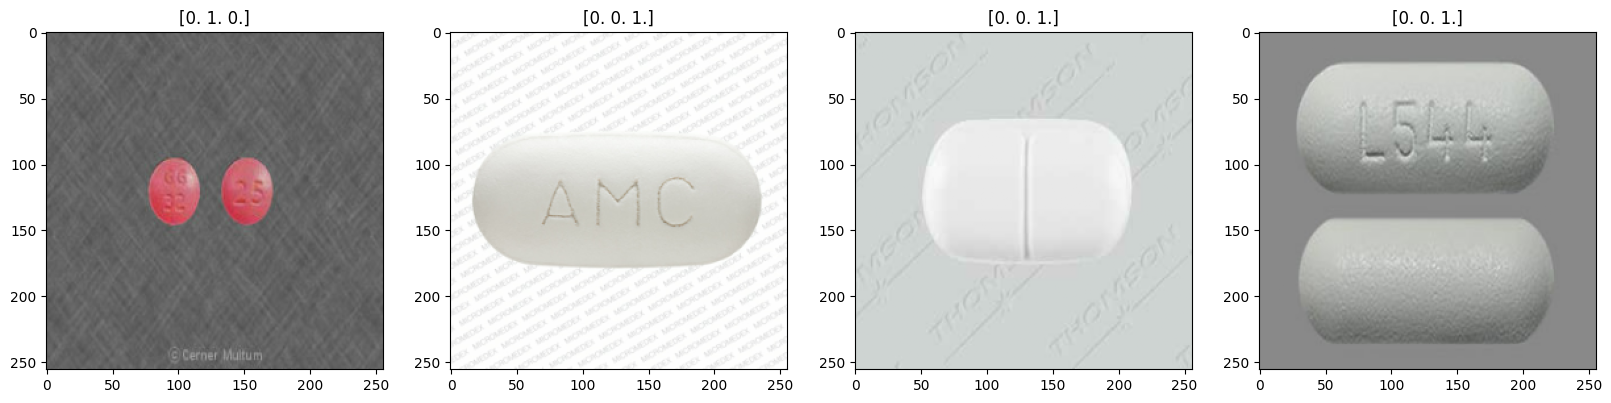

In [305]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
plt.show()

2.2 Split the data

In [306]:
len(data)

10

In [307]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)

In [308]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

3. Deep model

3.1 Build a deep learning model

In [309]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten

In [310]:
model=Sequential()

In [311]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [312]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [313]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_18                 │ (None, 127, 127, 16)        │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_19                 │ (None, 62, 62, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_20                 │ (None, 30, 30, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

3.2 Train

In [314]:
logdir='logs'

In [315]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [316]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.3335 - loss: 1.5381 - val_accuracy: 0.8750 - val_loss: 0.6743
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.8539 - loss: 0.5850 - val_accuracy: 0.9219 - val_loss: 0.2843
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.9161 - loss: 0.3095 - val_accuracy: 0.9375 - val_loss: 0.2302
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.9175 - loss: 0.2787 - val_accuracy: 0.8906 - val_loss: 0.2444
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.8908 - loss: 0.2660 - val_accuracy: 0.9062 - val_loss: 0.3767
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.9486 - loss: 0.2024 - val_accuracy: 0.9219 - val_loss: 0.2241
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.9653 - loss: 0.1520 - val_accuracy: 0.9531 - val_loss: 0.1946
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.9446 - loss: 0.1527 - val_accuracy: 0.9531 - val_loss:

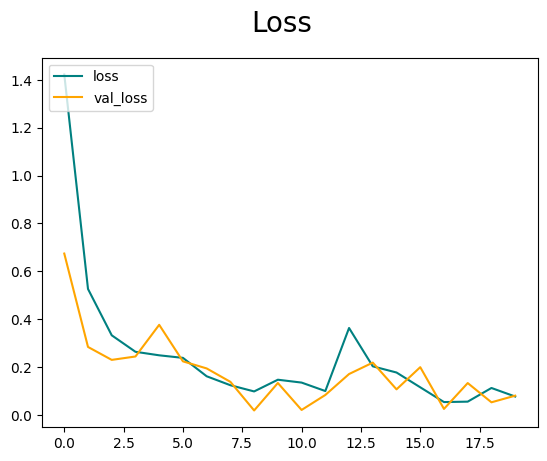

In [317]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

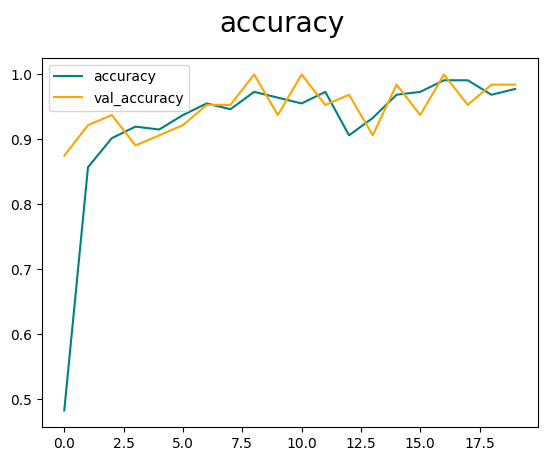

In [318]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

4. Evaluate performance

4.1 Evaluate

In [319]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [320]:
pre= Precision()
re= Recall()
acc= BinaryAccuracy()

In [321]:
len(test)

1

In [322]:
for batch in test.as_numpy_iterator():
    x, y =batch
    yhat= model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


In [323]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:1.0


4.2 Test

In [360]:
import cv2

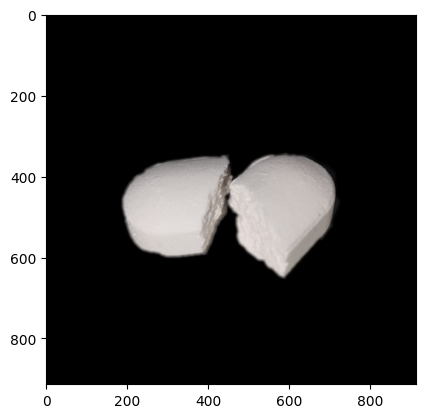

In [380]:
img=cv2.imread('cracked4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

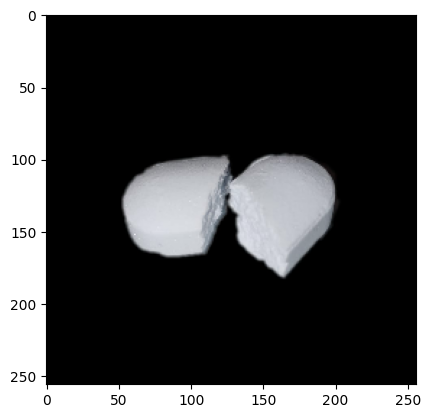

In [381]:
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [382]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [383]:
yhat

array([[0.93087864, 0.02186971, 0.04725162]], dtype=float32)

In [384]:
yhat.max()

0.93087864